<a href="https://colab.research.google.com/github/oymin2001/DataScience/blob/main/classifier_SGD_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
X,y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.6,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test,
}
print(X_train.shape)

(502, 64)


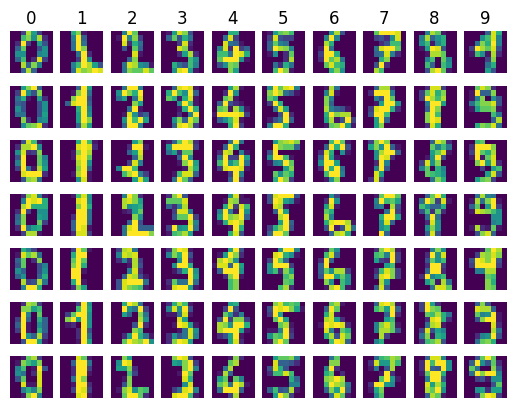

In [ ]:
classes = np.unique(y_test)
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape(8,8).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# 1. K-Nearest Neighbor

In [ ]:
class KNearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, n_neighbors=1,p=2):
        if p==1:
            dists = self.l1_distances(X)
        elif p==2:
            dists = self.l2_distances(X)
        else:
            raise ValueError("Invalid p")
        return self.predict_labels(dists, n_neighbors=n_neighbors)

    def l1_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            dists[i] = np.abs(X[i] - self.X_train).sum(axis=1)

        return dists

    def l2_distances(self,X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        dists = np.sqrt(np.sum(self.X_train**2, axis=1) + np.sum(X**2, axis=1).reshape(num_test,1) - 2*X.dot(self.X_train.T))
        return dists

    def predict_labels(self, dists, n_neighbors):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            closest_y = self.y_train[np.argsort(dists[i,:])[:n_neighbors]]
            val, cnt = np.unique(closest_y, return_counts=True)
            y_pred[i] = val[np.argmax(cnt)]

        return y_pred

In [ ]:
knn = KNearestNeighbor()
knn.train(X_train, y_train)

p_vals = [1, 2]
n_neighbors = [1,3,5,7]
best_score = -1
best_p, best_n = 0, 0

def get_acc(y_test, y_pred):
    return np.mean(y_test == y_pred)


for p, n_neighbor in itertools.product(p_vals, n_neighbors):
    y_val_pred = knn.predict(X_val, n_neighbors = n_neighbor, p=p)
    score = get_acc(y_val,y_val_pred)
    if score > best_score:
        best_score = score
        best_p, best_n = p, n_neighbor

print("BEST ACCURACY: ", best_score)
print(best_p, best_n)

BEST ACCURACY:  0.9953703703703703
2 3


In [ ]:
y_test_pred = knn.predict(X_test, n_neighbors = 3, p=2)
get_acc(y_test, y_test_pred)

0.9731232622798888

# 2. Linear Classifier

## optimization

In [ ]:
class optim(object):
    def __init__(self):
        pass

    def sgd(w, grads, config=None):
        if config is None:
            config = {}

        config.setdefault("learning_rate", 1e-2)
        w -= config['learning_rate']*grads
        return w, config

In [ ]:
class Solver(object): # SGD Solver
    def __init__(self, model, data, **kwargs):
        self.model = model
        self.X_train = data["X_train"]
        self.y_train = data["y_train"]
        self.X_val = data["X_val"]
        self.y_val = data["y_val"]

        self.update_rule = kwargs.pop("update_rule", "sgd")
        self.update_rule = getattr(optim, self.update_rule)
        self.optim_config = kwargs.pop("optim_config", {})
        self.lr_decay = kwargs.pop("lr_decay", 1.0)
        self.batch_size = kwargs.pop("batch_size", 100)
        self.num_epochs = kwargs.pop("num_epochs", 10)
        self.num_train_samples = kwargs.pop("num_train_samples", 1000)
        self.num_val_samples = kwargs.pop("num_val_samples", None)

        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.optim_configs = {} # {"W": {}, "b": {}, ...}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def _step(self):
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config

    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc

    def train(self):
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]["learning_rate"] *= self.lr_decay

            first_it = t == 0
            last_it = t == num_iterations - 1
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(
                    self.X_train, self.y_train, num_samples=self.num_train_samples
                )
                val_acc = self.check_accuracy(
                    self.X_val, self.y_val, num_samples=self.num_val_samples
                )
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)

                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        self.model.params = self.best_params

In [ ]:
class LinearClassifier(object):
    def __init__(self, input_dim=8*8, num_classes=10, weight_scale=1e-3, reg=0.0, no_loop=True):
        self.params = {'W' : np.random.randn(input_dim, num_classes) * weight_scale}
        self.reg = reg
        self.no_loop = no_loop

    def get_loss(self):
        return self.loss_hist


    def loss(self, X_batch, y_batch, reg):
        """
        Subclasses will override this.
        """
        pass

    def predict(self, X):
        y_pred = np.zeros(X.shape[0]) # num_trains
        W = self.params['W']
        scores = X.dot(W)
        y_pred = np.argmax(scores, axis=1)

        return y_pred

## 2.1 Linear Support Vector Machine (Hinge Loss)

In [ ]:
class LinearSVM(LinearClassifier): #hinge_loss, no bias
    def loss(self, X, y=None):
        W  = self.params['W']

        if y is None:
            return X.dot(W)

        if self.no_loop == True:
            return self.fast_loss(X, y, W)
        else:
            return self.loop_loss(X, y, W)

    def loop_loss(self, X, y, W):
        grads = {}
        dW = np.zeros(W.shape)
        num_class = W.shape[1]
        num_train = X.shape[0]
        loss = 0.0


        for i in range(num_train):
            scores = X[i].dot(W)
            for j in range(num_class):
                if j == y[i]: #correct
                    continue
                margin = scores[j] - scores[y[i]] + 1
                if margin > 0: # note that scores = max(0,s_j - correct + 1)
                    dW[:, y[i]] -= X[i]
                    dW[:, j] += X[i]

        loss /= num_train
        dW /= num_train

        loss += self.reg*np.sum(W**2)
        dW += 2*self.reg*W
        grads['W'] = dW

        return loss, grads

    def fast_loss(self, X, y, W):
        grads = {}
        loss = 0.0
        dW = np.zeros(W.shape)

        num_train = X.shape[0]
        scores = X.dot(W)
        margins = np.maximum(0, scores - scores[range(num_train), y].reshape(-1,1) + 1)
        margins[range(num_train), y] = 0
        loss = margins.sum() / len(y)
        loss += self.reg*np.sum(W**2)

        X_idx = np.zeros(margins.shape)
        X_idx[np.where(margins > 0)] = 1 # incorrect dx
        X_idx[range(num_train), y] = -X_idx.sum(axis=1) # correct dx
        dW = X.T.dot(X_idx) / num_train + 2*self.reg*W
        grads['W'] = dW

        return loss, grads

In [ ]:
import time

svm_with_loop = LinearSVM(no_loop=False)
lr=1e-2
solver = Solver(svm_with_loop, data, optim_config={'learning_rate': lr}, num_epochs=100)
tic = time.time()
solver.train()
toc = time.time()
print(toc-tic)

0.6589963436126709


In [ ]:
svm_no_loop = LinearSVM(no_loop=True)
solver = Solver(svm_no_loop, data, optim_config={'learning_rate': lr}, num_epochs=100)
tic = time.time()
solver.train()
toc = time.time()
print(toc-tic)

0.13002943992614746


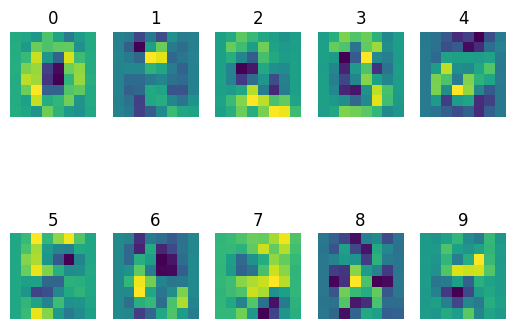

In [ ]:
w = svm_no_loop.params['W']
w = w.reshape(8,8,10)
w_min, w_max = w.min(), w.max()
for i in range(10):
    plt.subplot(2,5,i+1)
    w_scaled = 255*(w[:,:,i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(w_scaled)
    plt.axis('off')
    plt.title(classes[i])

In [ ]:
solver.best_val_acc

0.9675925925925926

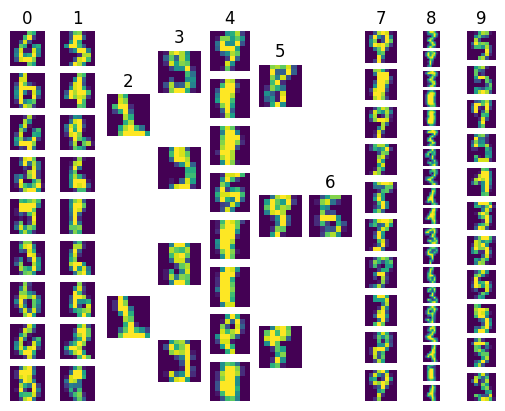

In [ ]:
tmp = 0
y_test_pred = svm_no_loop.predict(X_test)
for iter, target_name in enumerate(classes):
    idxs = np.where((y_test != target_name) & (y_test_pred == target_name))[0]
    for i, idx in enumerate(idxs):
        plt.subplot(len(idxs), 10, i*10+iter+1)
        plt.imshow(X_test[idx].reshape(8,8))
        plt.axis("off")
        if i==0:
            plt.title(target_name)

plt.show()

# 2.2 Softmax (Cross entropy)

In [ ]:
class Sofmax(LinearClassifier): #cross entropy_loss, no_bias
    def loss(self, X, y=None):
        W  = self.params['W']

        if y is None:
            return X.dot(W)
        if self.no_loop == True:
            return self.fast_loss(X, y, W)
        else:
            return self.loop_loss(X, y, W)

    def loop_loss(self, X, y, W):
        loss = 0.0
        grads = {}
        dW=  np.zeros(W.shape)
        stable_sotfmax = lambda x: np.exp(x-np.max(x)) / np.exp(x - np.max(x)).sum()
        num_train = X.shape[0]
        num_class = W.shape[1]

        for i in range(num_train):
            scores = X[i].dot(W)
            h = stable_sotfmax(scores)
            loss -= np.log(h[y[i]])

            for j in range(num_class):
                if(y[i] == j): continue
                dW[:,j] += h[j]*X[i]
            dW[:,y[i]] -= (1-h[y[i]]) * X[i]

        loss /= num_train
        dW /= num_train
        loss += self.reg*np.sum(W**2)
        dW += 2*self.reg*W
        grads['W'] = dW

        return loss, grads

    def fast_loss(self, X, y, W):
        loss = 0.0
        grads = {}
        dW = np.zeros(W.shape)
        num_train = X.shape[0]

        s = X.dot(W)
        h = np.exp(s - np.max(s)) / np.exp(s - np.max(s)).sum(axis=1).reshape(-1,1)

        loss = (-np.log(h[range(num_train), y])).sum() / num_train
        loss += self.reg*np.sum(W**2)

        h[range(num_train), y] -= 1
        dW = X.T.dot(h) / num_train
        dW += 2*self.reg*W
        grads['W'] = dW

        return loss, grads

In [ ]:
clf_with_loop = Sofmax(no_loop=False)
solver = Solver(clf_with_loop, data, optim_config={'learning_rate': lr}, num_epochs=100)
tic = time.time()
solver.train()
toc = time.time()
print(toc-tic)

3.6801764965057373


In [ ]:
clf_no_loop = Sofmax()
solver = Solver(clf_no_loop, data, optim_config={'learning_rate': lr}, num_epochs=100)
tic = time.time()
solver.train()
toc = time.time()
print(toc-tic)

0.14655804634094238


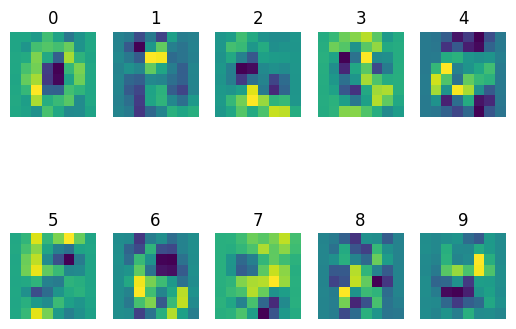

In [ ]:
w = clf_no_loop.params['W']
w = w.reshape(8,8,10)
w_min, w_max = w.min(), w.max()
for i in range(10):
    plt.subplot(2,5,i+1)
    w_scaled = 255*(w[:,:,i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(w_scaled)
    plt.axis('off')
    plt.title(classes[i])

In [ ]:
solver.best_val_acc

0.9814814814814815

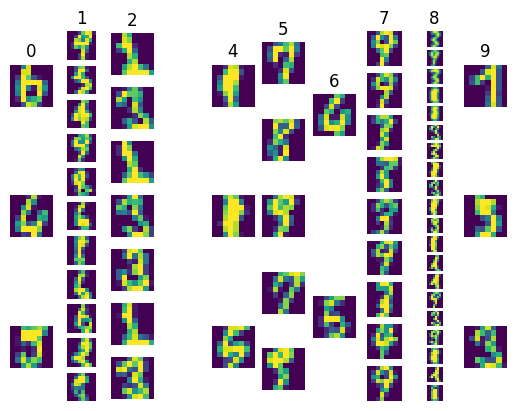

In [ ]:
tmp = 0
y_test_pred = clf_no_loop.predict(X_test)
for iter, target_name in enumerate(classes):
    idxs = np.where((y_test != target_name) & (y_test_pred == target_name))[0]
    for i, idx in enumerate(idxs):
        plt.subplot(len(idxs), 10, i*10+iter+1)
        plt.imshow(X_test[idx].reshape(8,8))
        plt.axis("off")
        if i==0:
            plt.title(target_name)

plt.show()

# 3. Neural Network

In [ ]:
class NeuralNetwork(object):
    def __init__(self, input_dim=8*8, hidden_dim=50, num_classes=10, weight_scale=1e-3, reg=0.0):
        self.params = {
            'W1': np.random.randn(input_dim, hidden_dim) * weight_scale,
            'b1': np.zeros(hidden_dim),
            'W2': np.random.randn(hidden_dim, num_classes) * weight_scale,
            'b2': np.zeros(num_classes)
        }
        self.reg = reg

    def affine_forward(self,x,w,b):
        D = w.shape[0]
        N = x.shape[0]

        out = x.reshape(N,D).dot(w) + b

        cache = (x, w, b)
        return out, cache

    def affine_backward(self, dout, cache):
        x,w,b = cache
        N = x.shape[0]
        D = w.shape[0]

        dx = dout.dot(w.T).reshape(x.shape)
        grads = x.reshape(N,D).T.dot(dout)
        db = dout.sum(axis=0)
        return dx, grads, db

    def relu_forward(self, x):
        out = np.maximum(0,x)
        cache = x
        return out, cache

    def relu_backward(self, dout, cache):
        dout[cache<=0] = 0
        dx = dout
        return dx

    def affine_relu_forward(self, x, w, b):
        a, fc_cache = self.affine_forward(x, w, b)
        out, relu_cache = self.relu_forward(a)
        cache = (fc_cache, relu_cache)
        return out, cache

    def affine_relu_backward(self, dout, cache):
        fc_cache, relu_cache = cache
        da = self.relu_backward(dout, relu_cache)
        dx, grads, db = self.affine_backward(da, fc_cache)
        return dx, grads, db

    def svm_loss(self, x, y):
        margins = np.maximum(0, x - x[range(len(y)), y].reshape(-1,1) + 1)
        margins[range(len(y)), y] = 0
        loss = margins.sum() / len(y)

        dx = (margins>0).astype(float)
        dx[range(len(y)), y] = -dx.sum(axis=1)
        dx /= len(y)

        return loss, dx

    def softmax_loss(self, x, y):
        h = np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum(axis=1).reshape(-1,1)
        loss = -np.log(h[range(len(y)), y]).sum() / len(y)

        h[range(len(y)), y] -= 1
        dx = h / len(y)

        return loss, dx


    def loss(self, X, y):
        pass

In [ ]:
class TwoLayer(NeuralNetwork):
    def loss(self, X, y=None):
        W1, b1, W2, b2 = self.params.values()
        out, cache1 = self.affine_relu_forward(X, W1, b1) # affine
        scores, cache2 = self.affine_forward(out, W2, b2) # - affine

        if y is None:
            return scores

        loss, grads = 0, {}

        loss, dloss = self.softmax_loss(scores, y)

        dscores, grads2, db2 = self.affine_backward(dloss, cache2)
        dout, grads1, db1 = self.affine_relu_backward(dscores, cache1)

        #regularization
        loss += 0.5 * self.reg * (np.sum(W1**2) + np.sum(W2**2))
        grads1 += self.reg*W1
        grads2 += self.reg*W2
        grads = {'W1': grads1, 'b1': db1, 'W2': grads2, 'b2': db2}

        return loss, grads

In [ ]:
nn = TwoLayer()
lr = 1e-2
solver = Solver(nn, data, optim_config={'learning_rate': lr}, num_epochs=100)
solver.train()
solver.best_val_acc

0.9490740740740741

In [ ]:
results = {}
best_val = -1

learning_rates = np.linspace(1e-2, 2.75e-2, 4)
regularization_strengths = np.geomspace(1e-6, 1e-4, 3)

net = TwoLayer()
best_net = None

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    # Create Two Layer Net and train it with Solver
    model = net
    solver = Solver(model, data, optim_config={'learning_rate': lr}, num_epochs=15, verbose=False)
    solver.train()

    # Compute validation set accuracy and append to the dictionary
    results[(lr, reg)] = solver.best_val_acc

    # Save if validation accuracy is the best
    if results[(lr, reg)] > best_val:
        best_val = results[(lr, reg)]
        best_net = model

for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (lr, reg, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-02 reg 1.000000e-06 val accuracy: 0.273148
lr 1.000000e-02 reg 1.000000e-05 val accuracy: 0.342593
lr 1.000000e-02 reg 1.000000e-04 val accuracy: 0.879630
lr 1.583333e-02 reg 1.000000e-06 val accuracy: 0.935185
lr 1.583333e-02 reg 1.000000e-05 val accuracy: 0.944444
lr 1.583333e-02 reg 1.000000e-04 val accuracy: 0.949074
lr 2.166667e-02 reg 1.000000e-06 val accuracy: 0.953704
lr 2.166667e-02 reg 1.000000e-05 val accuracy: 0.958333
lr 2.166667e-02 reg 1.000000e-04 val accuracy: 0.967593
lr 2.750000e-02 reg 1.000000e-06 val accuracy: 0.967593
lr 2.750000e-02 reg 1.000000e-05 val accuracy: 0.972222
lr 2.750000e-02 reg 1.000000e-04 val accuracy: 0.976852
best validation accuracy achieved during cross-validation: 0.976852


In [ ]:
y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.9388322520852641
